In [20]:
import mysql.connector 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [21]:
db = mysql.connector.connect(host= "localhost", username="root",password="NewPassword", database="ecommerce")

curr =db.cursor()

#   1. List all unique cities where customers are located.

In [17]:
query = "SELECT DISTINCT customer_city FROM customers"
curr.execute(query)
data = curr.fetchall()
df=pd.DataFrame(data, columns=['unique_cities'])
df

,unique_cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017.

In [18]:
query= "select count(order_id) from orders where year(order_purchase_timestamp)=2017;"

curr.execute(query)
data= curr.fetchall()

print(data)

[(45101,)]


# 3. Find the total sales per category.


In [19]:
query = """
SELECT SUM(price + freight_value), product_category 
FROM order_items 
JOIN products ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""

curr.execute(query)
data = curr.fetchall()

df= pd.DataFrame(data, columns=['total_sales_Categroywise', 'Product_category'])

df.rename({'Product_category':'Category', 'total_sales_Categroywise': 'total_sales'	},axis=1, inplace= True)
df['total_sales'] =df['total_sales'].round(1)

df.head()

,total_sales,Category
0,5764992.3,HEALTH BEAUTY
1,4626625.9,sport leisure
2,2877319.8,Cool Stuff
3,4237089.6,computer accessories
4,5222166.4,Watches present


# 4. Calculate the percentage of orders that were paid in installments.


In [6]:
query= '''select (sum(case when payment_installments >= 1 then 1 else 0 end)/count(*))*100 as payments_percentage from payments;'''
curr.execute(query)
data= curr.fetchall()
print('percentage of orders that were paid in installments are=',data[0][0],'%')

percentage of orders that were paid in installments are= 99.9981 %


 # 5. Count the number of customers from each state. 

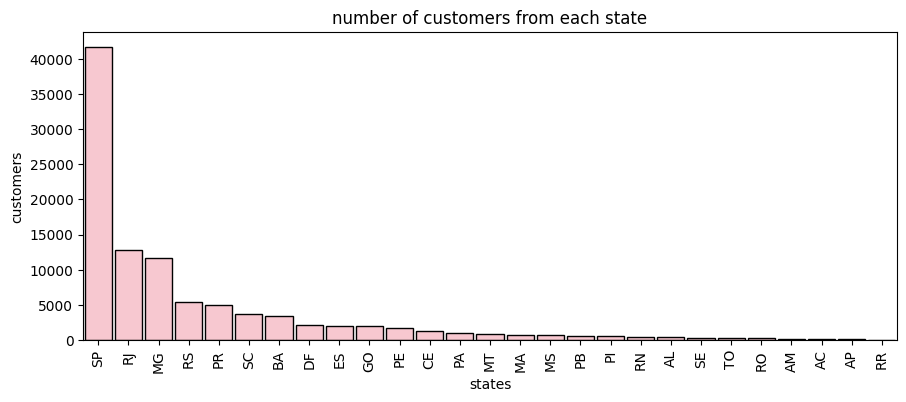

In [7]:
query= 'select count(customer_id) , customer_state from customers group by customer_state;'
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns=['No. of people', 'States'])
df= df.sort_values(by='No. of people', ascending=False)
df.head()

plt.figure(figsize=(10.5,4))
sns.barplot(x='States', y='No. of people',data=df, color='pink',width=0.9, edgecolor="black")
plt.xticks(rotation=90)
plt.xlabel('states')
plt.ylabel('customers')
plt.title('number of customers from each state')
plt.show()


# 6. Calculate the number of orders per month in 2018.

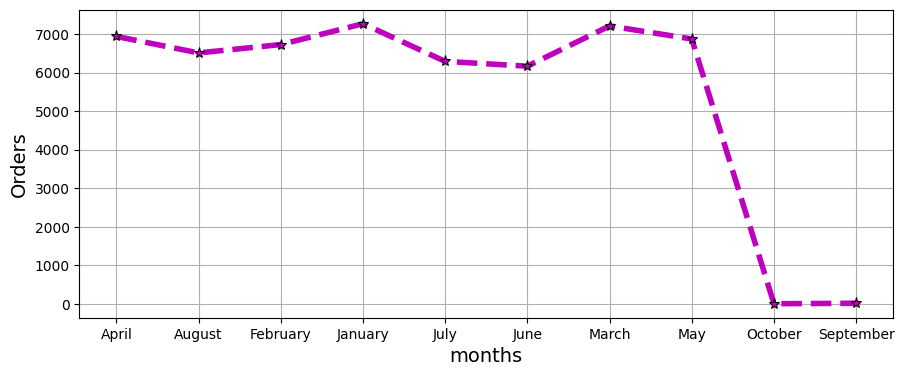

In [8]:
query=("""select monthname(order_purchase_timestamp) as 2018_Months, 
count(order_id) as per_month_orders from orders where 
year(order_purchase_timestamp)=2018 
group by monthname(order_purchase_timestamp);""")
o =["January", 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["2018_Months", "per_month_orders"])
df=df.sort_values(by='2018_Months', ascending= True)
plt.figure(figsize=(10.5,4))
sns.lineplot(x=df['2018_Months'], y=df['per_month_orders'], data=df, linestyle='--', linewidth=4, color='m', marker='*', markeredgecolor='black', markersize=8)
plt.xlabel("months",size=14)
plt.ylabel("Orders", size=14)
plt.grid()
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [9]:
query="""with count_per_order as (select orders.order_id, orders.customer_id, 
count(order_items.order_id) as oc 
from orders 
join order_items on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,
round(avg(count_per_order.oc),2) as Average_order
from customers 
join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by  customers.customer_city;"""

curr.execute(query)
data= curr.fetchall()
df=pd.DataFrame(data, columns=['City','Average_Products_per_order'])
df= df.sort_values(by="Average_Products_per_order", ascending=False)
df.head(11)


,City,Average_Products_per_order
2538,padre carvalho,14.00
1529,celso ramos,13.00
3076,candido godoi,12.00
3898,datas,12.00
3543,matias olimpio,10.00
3487,cidelandia,8.00
3668,teixeira soares,8.00
3823,curralinho,8.00
3435,morro de sao paulo,8.00
3664,picarra,8.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query="""select round((sum(price + freight_value)/(select sum(payment_value)from payments))*100,2)
as  final_Price_percentage,
product_category from order_items 
join products on products.product_id= order_items.product_id
group by products.product_category;"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns=["revenue_percentage", "category"])
df.head(6)

,revenue_percentage,category
0,18.01,HEALTH BEAUTY
1,14.45,sport leisure
2,8.99,Cool Stuff
3,13.23,computer accessories
4,16.31,Watches present
5,9.72,housewares


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query ="""select products.product_category, count(Order_items.product_id) order_count, 
round(avg(order_items.price),2) price
from 
order_items join products 
on products.product_id= order_items.product_id group by product_category;"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns=['product_category','order_count','price'])
df.head()

arr1= df['order_count']
arr2=df['price']
print('Corelation between price and order count=',np.corrcoef([arr1,arr2]))


Corelation between price and order count= [[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

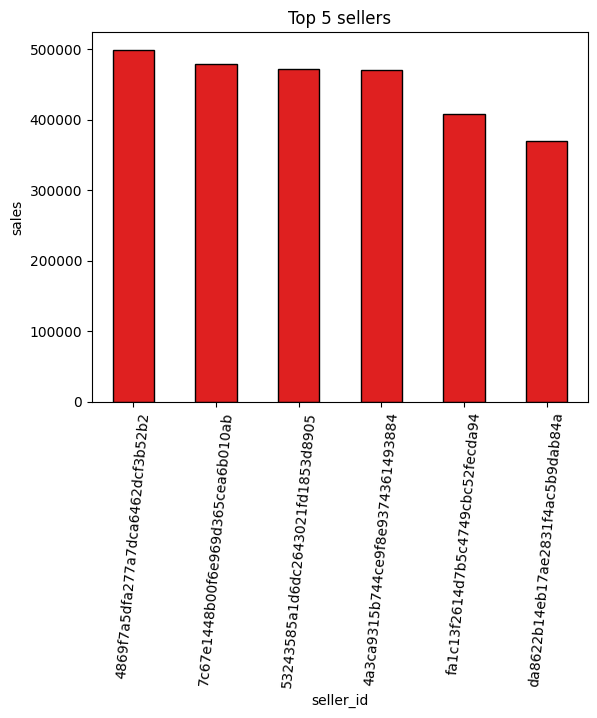

In [12]:
query= """select sellers.seller_id, count(order_items.order_id) as total_orders, 
round(sum(order_items.price+order_items.freight_value),2) as sales, 
rank() over ( order by round(sum(order_items.price+order_items.freight_value),2) desc) 
as Seller_ranking from
order_items join sellers on
order_items.seller_id = sellers.seller_id group by (sellers.seller_id);"""

curr.execute(query)
data=curr.fetchall()

df=pd.DataFrame(data, columns=['seller_id','total_orders','sales','Seller_ranking'])
df2=df.head(6)
sns.barplot(x= 'seller_id', y= 'sales', data=df2, color="red", width=0.5,edgecolor='black')
plt.xticks(rotation=85)
plt.title("Top 5 sellers")
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [13]:
query = """select customer_id , order_purchase_timestamp, payment, avg(payment) over 
(partition by customer_id order by order_purchase_timestamp
asc rows between 2 preceding and current row ) as moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from orders join payments on 
orders.order_id= payments.order_id) as main_table;"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns = ['customer id', 'order time stamp', 'payments','moving average'])
df['moving average']= round(df['moving average'],5)
df.head(6)

,customer id,order time stamp,payments,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42


# 12. Calculate the cumulative sales per month for each year.

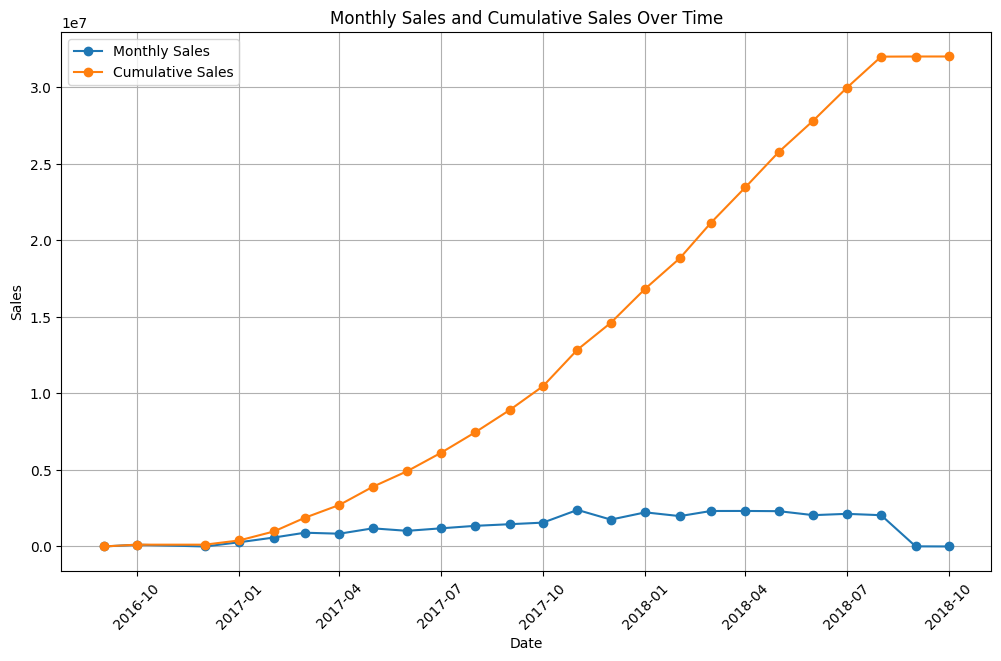

In [14]:
query= """select*, sum(sales) over(order by year, month) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) year,
month(orders.order_purchase_timestamp) month,
sum(payments.payment_value) as sales from payments 
join orders on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp) ,
month(orders.order_purchase_timestamp) order by year(orders.order_purchase_timestamp) ,
month(orders.order_purchase_timestamp)) as sales;"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns = ['Year', 'Month', 'Sales','Cumulative_sales'])
df['Cumulative_sales']= np.round(df['Cumulative_sales'],2)
df['Sales']= np.round(df['Sales'],2)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
plt.figure(figsize=(12,7))
plt.plot(df['Date'], df['Sales'], marker='o', label='Monthly Sales')
plt.plot(df['Date'], df['Cumulative_sales'], marker='o', label='Cumulative Sales')
plt.title('Monthly Sales and Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# 13. Calculate the year-over-year growth rate of total sales.

In [27]:
query= """with a as (select year(orders.order_purchase_timestamp) year,
round(sum(payments.payment_value),2) as sales from payments 
join orders on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp))

select year, ((sales-lag(sales, 1)over (order by year))/ lag(sales, 1)over (order by year))*100 as YOY_Growth   from a;"""

curr.execute(query)
data=curr.fetchall()
df= pd.DataFrame(data, columns=['year', "YOY%_Growth"])
df

,year,YOY%_Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.